# Financial analysis of OZON 

Before analyzing the data, we need to prepare it. First, let's import the necessary libraries.

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gspread
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline


Next, connect to Google Sheets using the GSpread library and extract OZON’s data.

In [95]:
# Connect to Google Sheets using service account credentials 
gc = gspread.service_account(filename=r'C:\Users\first-scarab (key).json')

# Access OZON financial datasets 
ozon_financial_statements = gc.open('OZON - отчетность')
ozon_operating_results = gc.open('OZON - показатели деятельности')
ozon_financial_ratios = gc.open('OZON - финансовые коэффициенты')

# Assign specific worksheets to variables 
balanceq_sheet = ozon_financial_statements.get_worksheet(1) # Balance Sheet
plq_sheet = ozon_financial_statements.get_worksheet(3)      # Profit & Loss  
cfq_sheet = ozon_financial_statements.get_worksheet(5)      # Cash Flow 
orq_sheet = ozon_operating_results.get_worksheet(1)         # Operating Results 
fr_sheet = ozon_financial_ratios.get_worksheet(1)           # Financial Ratios 

# Convert sheets to Pandas DataFRames
ozon_blq = pd.DataFrame(balanceq_sheet.get('B3:ZZ45'))
ozon_plq = pd.DataFrame(plq_sheet.get('B3:ZZ26'))
ozon_cfq = pd.DataFrame(cfq_sheet.get('B3:ZZ53'))
market_place = pd.DataFrame(orq_sheet.get('B3:ZZ6'))
metrics = pd.DataFrame(orq_sheet.get('B11:ZZ16'))
revenue_structure = pd.DataFrame(orq_sheet.get('B21:ZZ29'))
cost_structure = pd.DataFrame(orq_sheet.get('B35:ZZ42'))
ozon_fr = pd.DataFrame(fr_sheet.get('B3:ZZ42'))

# Display settings
pd.set_option('display.precision', 2)

After that, we need to clean our data: 
- remove all missing values 
- fill empty spaces 
- ensure uniform formatting 
- standardize date displays
- scale numerical values for compactness


In [97]:
ozon_blq.dropna(inplace=True) # Remove missing values
ozon_blq.reset_index(drop=True, inplace=True) # Reset index to remove gaps
ozon_blq.iloc[1:, 1:] = ozon_blq.iloc[1:, 1:].apply(pd.to_numeric) # Convert string values to numeric
ozon_blq.iloc[1:, 1:] = ozon_blq.iloc[1:, 1:] / 1000000 # Scale values to billions (divide by 1M)
ozon_blq.iloc[0, 1:] = pd.to_datetime(ozon_blq.iloc[0, 1:], format='%d.%m.%Y').dt.strftime('%d-%m-%Y') # Convert date format to DD-MM-YYYY


ozon_plq.dropna(inplace=True)
ozon_plq.reset_index(drop=True, inplace=True)
ozon_plq.iloc[1:, 1:] = ozon_plq.iloc[1:, 1:].apply(pd.to_numeric)
ozon_plq.iloc[1:, 1:] = ozon_plq.iloc[1:, 1:] / 1000000 
ozon_plq.iloc[0, 1:] = ozon_plq.iloc[0, 1:].str.slice_replace(1, 5, 'q') # Format dates as quarters
ozon_plq.iloc[0, 1:] = ozon_plq.iloc[0, 1:].str.slice_replace(-2)


ozon_cfq.dropna(inplace=True)
ozon_cfq.reset_index(drop=True, inplace=True)
ozon_cfq.iloc[1:, 1:] = ozon_cfq.iloc[1:, 1:].apply(pd.to_numeric)
ozon_cfq.iloc[1:, 1:] = ozon_cfq.iloc[1:, 1:] / 1000000
ozon_cfq.iloc[0, 3:] = ozon_cfq.iloc[0, 3:].str.slice_replace(1, 5, 'q')
ozon_cfq.iloc[0, 3:] = ozon_cfq.iloc[0, 3:].str.slice_replace(-2)
ozon_cfq.iloc[0, 1:3] = ozon_cfq.iloc[0, 1:3].str.slice_replace(1, 6, 'm')
ozon_cfq.iloc[0, 1:3] = ozon_cfq.iloc[0, 1:3].str.slice_replace(-2)


market_place.iloc[1:, 0] = market_place.iloc[1:, 0].map(str) + ', ' + market_place.iloc[1:, 1].map(str) # Join two text columns into one
market_place.drop(columns=1, inplace=True)
market_place.iloc[0, 0] = 'Metric'
market_place.columns = range(market_place.shape[1])
market_place.iloc[1:, 2:] = market_place.iloc[1:, 2:].apply(pd.to_numeric)
market_place.iloc[0, 2:] = market_place.iloc[0, 2:].str.slice_replace(1, 5, 'q')
market_place.iloc[0, 2:] = market_place.iloc[0, 2:].str.slice_replace(-2)
market_place.fillna(0, inplace=True) # Fill NA values with zeros


metrics.iloc[1:, 0] = metrics.iloc[1:, 0].map(str) + ', ' + metrics.iloc[1:, 1].map(str)
metrics.drop(metrics.columns[1:5], inplace=True, axis=1)
metrics.columns = range(metrics.shape[1])
metrics.ffill(inplace=True, axis=1) # Forward fill NA values
metrics.iloc[1:, 1:] = metrics.iloc[1:, 1:].replace(r'^\s*$', np.nan, regex=True)
metrics.bfill(inplace=True, axis=1) # Backward fill remaining NA values
metrics.iloc[1:, 1:] = metrics.iloc[1:, 1:].apply(pd.to_numeric)
metrics.iloc[0, 1:] = metrics.iloc[0, 1:].str.slice_replace(1, 5, 'q')
metrics.iloc[0, 1:] = metrics.iloc[0, 1:].str.slice_replace(-2)


revenue_structure.iloc[1:, 0] = revenue_structure.iloc[1:, 0].map(str) + ', ' + revenue_structure.iloc[1:, 1].map(str)
revenue_structure.drop(revenue_structure.columns[1:4], axis=1, inplace=True)
revenue_structure.columns = range(revenue_structure.shape[1])
revenue_structure.fillna(0, inplace=True)
revenue_structure.iloc[0, 1:] = revenue_structure.iloc[0, 1:].str.slice_replace(1, 5, 'q')                                                      
revenue_structure.iloc[0, 1:] = revenue_structure.iloc[0, 1:].str.slice_replace(-2)                                                     
revenue_structure.iloc[1:, 1:] = revenue_structure.iloc[1:, 1:].apply(pd.to_numeric)
revenue_structure.iloc[1:, 1:] = revenue_structure.iloc[1:, 1:] / 1000000

 
cost_structure.iloc[1:, 0] = cost_structure.iloc[1:, 0].map(str) + ', ' + cost_structure.iloc[1:, 1].map(str)
cost_structure.drop(cost_structure.columns[1:4], axis=1, inplace=True)
cost_structure.columns = range(cost_structure.shape[1])
cost_structure.iloc[0, 1:] = cost_structure.iloc[0, 1:].str.slice_replace(1, 5, 'q')
cost_structure.iloc[0, 1:] = cost_structure.iloc[0, 1:].str.slice_replace(-2)
cost_structure.iloc[1:, 1:] = cost_structure.iloc[1:, 1:].apply(pd.to_numeric)*-1 # Convert costs to positive values
cost_structure.iloc[1:, 1:] = cost_structure.iloc[1:, 1:] / 1000000
                                                  

ozon_fr.iloc[0, 1:] = pd.to_datetime(ozon_fr.iloc[0, 1:], format='%d.%m.%Y').dt.strftime('%d-%m-%Y')
ozon_fr.iloc[1:, 1:] = ozon_fr.iloc[1:, 1:].apply(pd.to_numeric)

Now, let’s start visualizing the data. First, we’ll plot GMV (Gross Merchandise Value) to assess the overall sales performance.

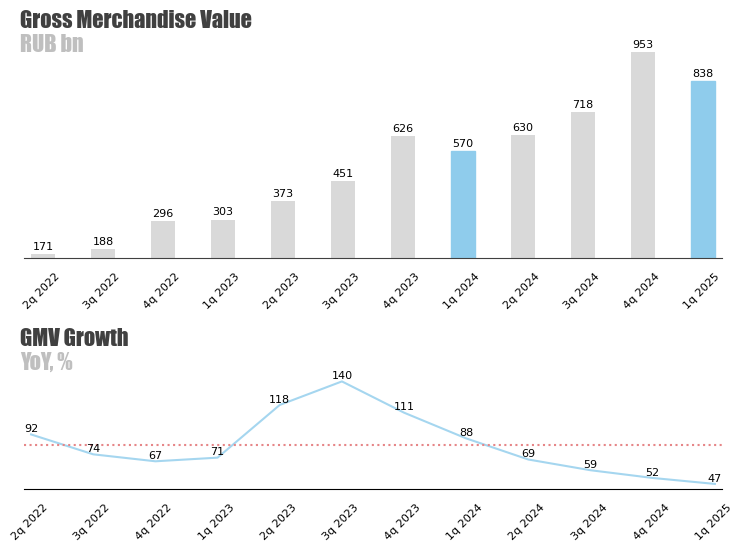

In [98]:
# Basic settings for visualizations
colors = ['#AFD5C1', '#E68688', '#F1D078', '#8FCCEC', '#EEAF9D', '#C4B2D6', '#A0A0A0']
font = {'fontname': 'Impact'}
f_colors = ['#404040', '#BFBFBF', '#D9D9D9']


# Control the number of quarters analyzed in each graph
quarters_analysed = 12
dates_q = ozon_plq.iloc[0, -quarters_analysed:]  # Format dates as quarterly periods (e.g., 4Q 2024)
dates_n = ozon_blq.iloc[0, -quarters_analysed:]  # Format dates as numeric values (e.g., 31-12-2024)


# Create a bar chart of Gross Merchandise Value (GMV) with a growth line plot below
GMV_figure, (gmv, gmvp) = plt.subplots(2, 1, figsize=(9, 6), height_ratios=(1.5, 1))
bars = gmv.bar(dates_q, market_place.iloc[1, -quarters_analysed:], color=f_colors[2], width=0.4)
for i in [-1, -5]:                    # Highlight the last quarter and its year-ago equivalent by changing their colors
    bars[i].set_color(colors[3])
gmv.set_ylim(market_place.iloc[1, -quarters_analysed:].min() * 0.9, market_place.iloc[1, -quarters_analysed:].max() * 1.1)
plt.subplots_adjust(hspace=0.4)
gmv.xaxis.set_tick_params(rotation=45, labelsize=8) # Rotate x-axis ticks and adjust label size
gmv.yaxis.set_visible(False) 
gmv.margins(x=0.01)
gmv.xaxis.set_ticks_position('none')   # Remove all axis ticks
for key, spine in gmv.spines.items():  # Remove three spines (keeping only the bottom spine) for cleaner visualization
    if key != 'bottom':
        spine.set_visible(False)
gmv.spines['bottom'].set_color(f_colors[0])
for i in range(len(dates_q)):
    gmv.text(dates_q.iloc[i],  market_place.iloc[1, -quarters_analysed + i] + market_place.iloc[1, -quarters_analysed:].max() * 0.02, str(round(market_place.iloc[1, -quarters_analysed + i])),
             ha='center', fontsize=8)
GMV_figure.text(0.12, 0.88, 'Gross Merchandise Value', fontsize=16, color=f_colors[0], **font)
GMV_figure.text(0.12, 0.84, 'RUB bn', fontsize=16, color=f_colors[1], **font)
gmvp.plot(dates_q, market_place.iloc[3, -quarters_analysed:], color=colors[3], alpha=0.8)
gmvp.xaxis.set_tick_params(rotation=45, labelsize=8)
for key, spine in gmvp.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
gmvp.xaxis.set_ticks_position('none')
gmvp.margins(x=0.01)
gmvp.yaxis.set_visible(False)
gmvp.set_ylim(market_place.iloc[3, -quarters_analysed:].min() * 0.9, market_place.iloc[3, -quarters_analysed:].max() * 1.3)
for i in range(len(dates_q)):
    gmvp.text(dates_q.iloc[i], market_place.iloc[3, -quarters_analysed + i] + market_place.iloc[3, -quarters_analysed:].max() * 0.02,
              str(round(market_place.iloc[3, -quarters_analysed + i])), ha='center', fontsize=8)
GMV_figure.text(0.12, 0.35, 'GMV Growth', fontsize=16, color=f_colors[0], **font)
GMV_figure.text(0.12, 0.31, 'YoY, %', fontsize=16, color=f_colors[1], **font)
gmvp.axhline(y=market_place.iloc[3, -quarters_analysed:].mean(), color=colors[1], linestyle="dotted") # Add a horizontal line at the mean value
plt.show()

In Q1 2025, GMV grew by 46.9% YoY, from RUB 570 bn to RUB 838 bn, which is objectively a good result. However, its growth rate continued to slow down, hitting a historic low of 47% and plunging below the mean (red line). To understand the reasons behind it, we need to look into the order volume and client base. 

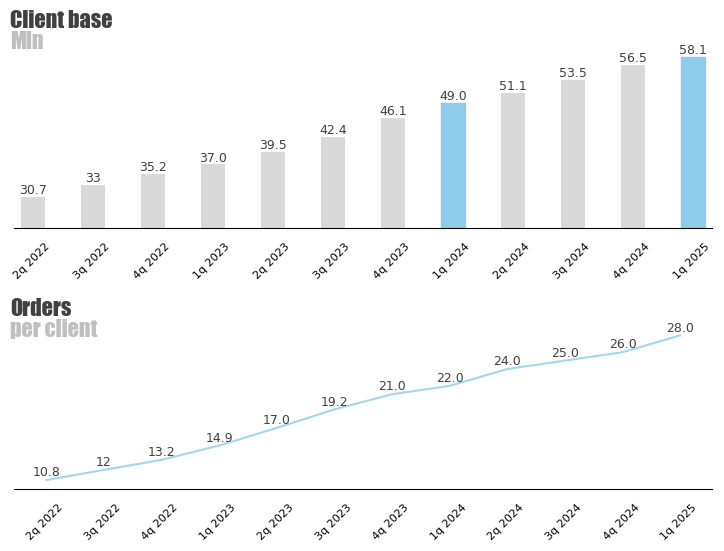

In [99]:
# Create a client base graph
Metrics_figure, (cbv, avo) = plt.subplots(2, 1, figsize=(9, 6))
mbars = cbv.bar(dates_q, metrics.iloc[2, -quarters_analysed:], color=f_colors[2], width=0.4)
for i in [-1,-5]:
    mbars[i].set_color(colors[3])
cbv.xaxis.set_tick_params(rotation=45, labelsize=8)
cbv.set_ylim(metrics.iloc[2, -quarters_analysed:].min() * 0.8, metrics.iloc[2, -quarters_analysed:].max() * 1.1)
cbv.yaxis.set_visible(False)
for key, spine in cbv.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
cbv.margins(x=0.01)
cbv.xaxis.set_ticks_position('none')
for i in range(len(dates_q)):
    cbv.text(dates_q.iloc[i], metrics.iloc[2, -quarters_analysed + i] + metrics.iloc[2, -quarters_analysed:].max() * 0.013,
             str(round(metrics.iloc[2, -quarters_analysed + i], 1)), ha='center', fontsize=9, color=f_colors[0])
cbv.margins(x=0.01)
Metrics_figure.text(0.12, 0.88, 'Client base', fontsize=16, color=f_colors[0], **font)
Metrics_figure.text(0.12, 0.845, 'Mln', fontsize=16, color=f_colors[1], **font)
avo.plot(dates_q, metrics.iloc[4, -quarters_analysed:], color=colors[3], alpha=0.8)
avo.xaxis.set_tick_params(rotation=45, labelsize=8)
avo.yaxis.set_visible(False)
avo.xaxis.set_ticks_position('none')
for key, spine in avo.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
Metrics_figure.text(0.12, 0.40, 'Orders', fontsize=16, color=f_colors[0], **font)
Metrics_figure.text(0.12, 0.365, 'per client', fontsize=16, color=f_colors[1], **font)
avo.set_ylim(metrics.iloc[4, -quarters_analysed:].min() * 0.9, metrics.iloc[4, -quarters_analysed:].max() * 1.2)
for i in range(len(dates_q)):
    avo.text(dates_q.iloc[i], metrics.iloc[4, -quarters_analysed + i] + metrics.iloc[4, -quarters_analysed:].max() * 0.02, str(round(metrics.iloc[4, -quarters_analysed + i], 1)),
             ha='center', fontsize=9, color=f_colors[0])
plt.subplots_adjust(hspace=0.3)
plt.show()


In the last quarter, the client base added 1.6 mln new clients, reaching a new historic high of 58.1 mln people. On average, for the last 12 quarters, OZON was adding around 2.6 mln people, which is significantly higher than the last result. It can be explained by the scale of the organization; as it slowly reaches its critical mass, attracting new customers becomes increasingly difficult. Also, we need to keep in mind that there is 140 mln people in Russia, and only about 75 mln are part of the workforce. Therefore, slowing in this aspect is understandable and shouldn't be attributed to the company's strategy. 

The good news is the average number of orders per client keeps growing. In Q1 2025, it increased to 28 orders, from 22 orders a year earlier. It means that the company manages to successfully integrate new clients into its ecosystem and incentivize them to purchase more often. For reference, Amazon's average number of orders per customer is 73, so there is more than enough room for growth. 

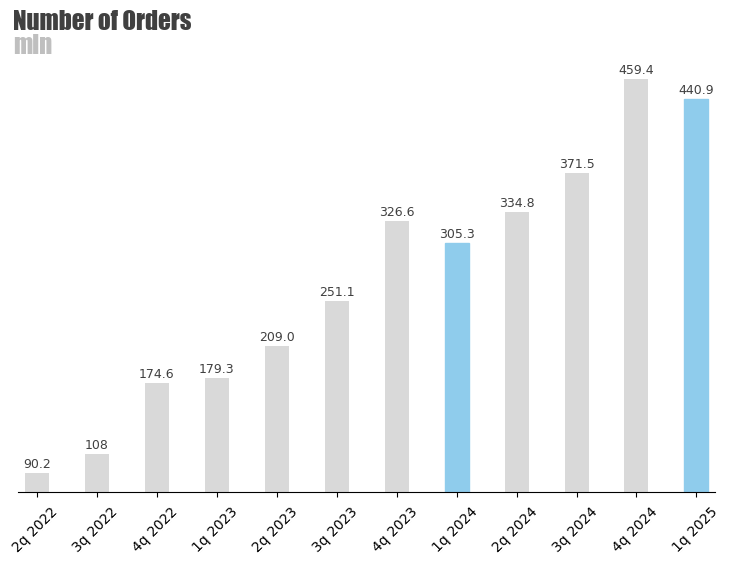

In [100]:
# Create an order volume graph
Orders_figure, onv = plt.subplots(figsize=(9, 6))
bars = onv.bar(dates_q, metrics.iloc[1, -quarters_analysed:], width=0.4, color=f_colors[2])
for i in [-1,-5]:
    bars[i].set_color(colors[3]) 
onv.xaxis.set_tick_params(rotation=45, labelsize=10)
onv.yaxis.set_visible(False)  
for key, spine in onv.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
onv.margins(x=0.01)
onv.set_ylim(metrics.iloc[1, -quarters_analysed:].min() * 0.8, metrics.iloc[1, -quarters_analysed:].max() * 1.1)
for i in range(len(dates_q)):
    onv.text(dates_q.iloc[i], metrics.iloc[1, -quarters_analysed + i] + metrics.iloc[1, -quarters_analysed:].max() * 0.01, 
             str(round(metrics.iloc[1, -quarters_analysed + i], 1)), ha='center', fontsize=9, color=f_colors[0])
Orders_figure.text(0.12, 0.88, 'Number of Orders', fontsize=18, color=f_colors[0], **font)
Orders_figure.text(0.12, 0.84, 'mln', fontsize=18, color=f_colors[1], **font)
plt.show()


Due to the higher purchase frequency and growing customer base, the total number of orders rose by 44.4% YoY, to 440.9 mln, and is highly likely to continue in this direction. 

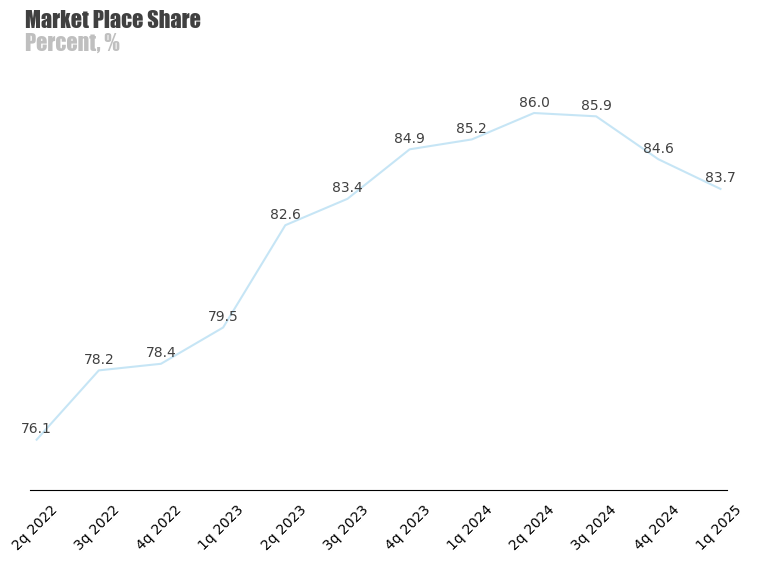

In [ ]:
# Create a market place share graph
Market_share_figure, msv = plt.subplots(figsize=(9, 6))
msv.plot(dates_q, market_place.iloc[2, -quarters_analysed:], color=colors[3], alpha=0.5)
msv.xaxis.set_tick_params(rotation=45, labelsize=10)
msv.yaxis.set_visible(False)
for key, spine in msv.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
msv.xaxis.set_ticks_position('none')
for i in range(len(dates_q)):
    msv.text(dates_q.iloc[i], market_place.iloc[2, -quarters_analysed + i] + 0.2, 
             str(round(market_place.iloc[2, -quarters_analysed + i], 1)), fontsize=10, color=f_colors[0], ha='center')
msv.set_ylim(market_place.iloc[2, -quarters_analysed:].min() * 0.98, market_place.iloc[2, -quarters_analysed:].max() * 1.03)
msv.margins(x=0.01)
Market_share_figure.text(0.12, 0.88, 'Market Place Share', fontsize=16, color=f_colors[0], **font)
Market_share_figure.text(0.12, 0.842, 'Percent, %', fontsize=16, color=f_colors[1], **font)
plt.show()

The share of OZON's marketplace (third-party sales) in its GMV has been in decline for the last two quarters but consistently stays around 84%. In theory, it should be good, because selling own products is more profitable than commissioning the products of others, but in reality it might mean nothing. The company has a history of selling products with a near-zero margin to attract new customers, so the increase in the first-party sales may have little to no effect on the profitability.  

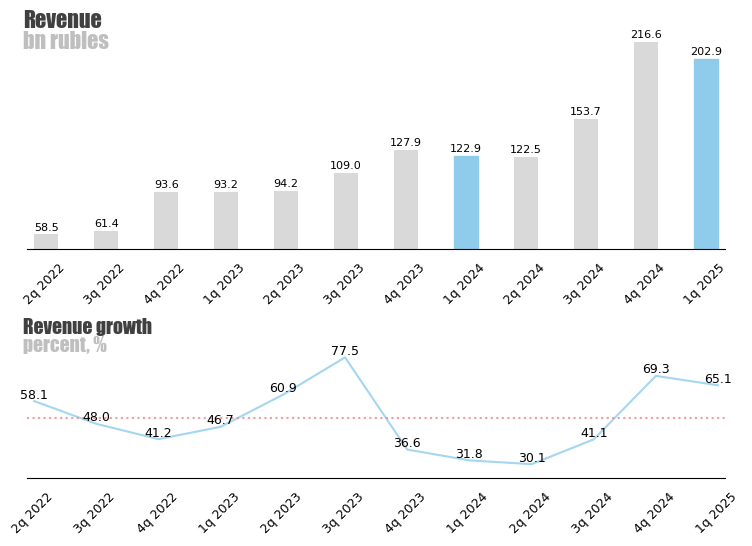

In [101]:
# Create a revenue graph
Revenue_figure, (rvv,rvg) = plt.subplots(2,1, figsize=(9, 6), height_ratios=(1.5, 1))
bars = rvv.bar(dates_q, ozon_plq.iloc[1, -quarters_analysed:], width=0.4, color=f_colors[2])
for i in [-1, -5]:
    bars[i].set_color(colors[3])
rvv.xaxis.set_tick_params(rotation=45, labelsize=9)
rvv.xaxis.set_ticks_position('none')
rvv.set_ylim(ozon_plq.iloc[1, -quarters_analysed:].min() * 0.8, ozon_plq.iloc[1, -quarters_analysed:].max() * 1.1)
Revenue_figure.text(0.12, 0.86, 'Revenue', fontsize=16, color=f_colors[0], **font)
Revenue_figure.text(0.12, 0.825, 'bn rubles', fontsize=16, color=f_colors[1], **font)
rvv.margins(x=0.01)
for i in range(len(dates_q)):
    rvv.text(dates_q.iloc[i], ozon_plq.iloc[1, -quarters_analysed + i] + ozon_plq.iloc[1, -quarters_analysed:].max() * 0.015,
             str(round(ozon_plq.iloc[1, -quarters_analysed + i], 1)), ha='center', fontsize=8)
rvv.yaxis.set_visible(False)
for key, spine in rvv.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
plt.subplots_adjust(hspace=0.38)
revenue_growth = round(ozon_plq.iloc[1, -quarters_analysed - 4:].pct_change(periods=4).dropna() * 100, 1)
rvg.plot(dates_q, revenue_growth, color=colors[3], alpha=0.8)
rvg.xaxis.set_tick_params(rotation=45, labelsize=9)
rvg.xaxis.set_ticks_position('none')
rvg.set_ylim(revenue_growth.min() * 0.8, revenue_growth.max() * 1.2)
Revenue_figure.text(0.12, 0.35, 'Revenue growth', fontsize=14, color=f_colors[0], **font)
Revenue_figure.text(0.12, 0.32, 'percent, %', fontsize=14, color=f_colors[1], **font)
rvg.margins(x=0.01)
for i in range(len(dates_q)):
    rvg.text(dates_q.iloc[i], revenue_growth.iloc[i] + revenue_growth.max() * 0.015, 
             str(revenue_growth.iloc[i]), ha='center', fontsize=9)
rvg.yaxis.set_visible(False)
for key, spine in rvg.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
rvg.axhline(y=revenue_growth.mean(), color=colors[1], alpha=0.8, linestyle='dotted')
plt.show()

The revenue's dynamic is much better than GMV's. It grew by 65.1% YoY, to RUB 202.9 bn, and its growth rate stays above the historic average (red line).

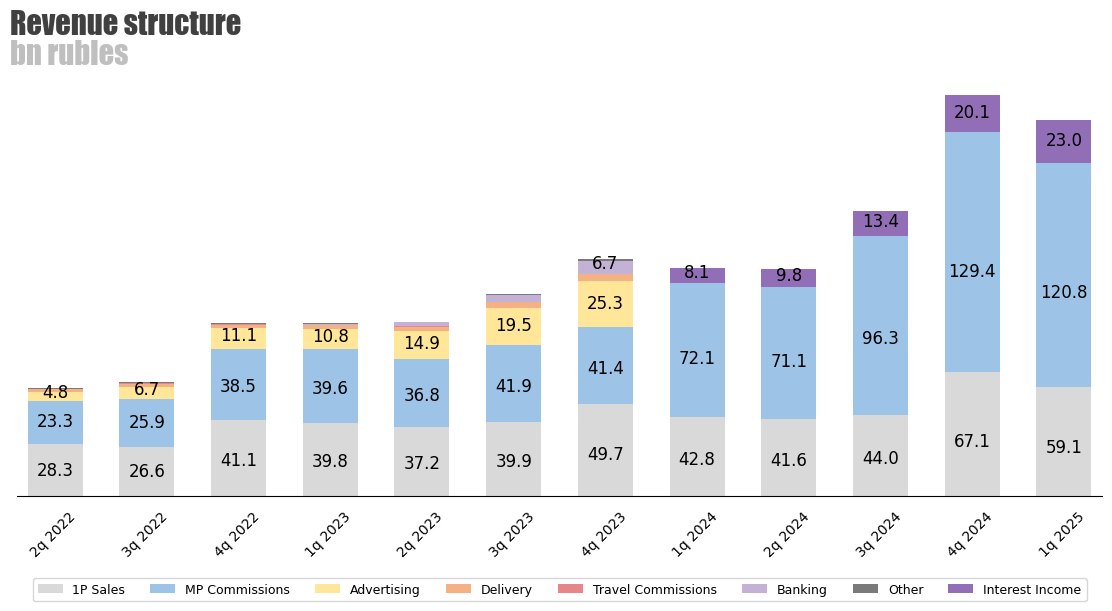

In [102]:
labels = ['1P Sales', 'MP Commissions', 'Advertising', 'Delivery', 'Travel Commissions', 'Banking', 'Other', 'Interest Income']
ozon_colors = ['#D9D9D9', '#9DC3E6', '#FFE699', '#F4B183', '#E68688','#C4B2D6', '#7A7A7A', "#926EB6"]

# Create a revenue structure graph
Revenue_str_figure, rsv = plt.subplots(figsize=(14, 6))
for i in range(len(revenue_structure.iloc[1:, -quarters_analysed:])):
    rsv.bar(dates_q, revenue_structure.iloc[1 + i, -quarters_analysed:], color=ozon_colors[i],
            bottom=revenue_structure.iloc[1:i + 1, -quarters_analysed:].sum(), label=labels[i], width=0.6) 
rsv.xaxis.set_tick_params(rotation=45, labelsize=10)
rsv.margins(x=0.01)
rsv.xaxis.set_ticks_position('none')
rsv.set_ylim(0, revenue_structure.iloc[1:, -quarters_analysed:].sum().max() * 1.15)
rsv.legend(loc='lower center', bbox_to_anchor=(0.5, -0.24), ncol=8, fontsize=9)
rsv.yaxis.set_visible(False)
for key, spine in rsv.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
Revenue_str_figure.text(0.12, 0.88, 'Revenue structure', fontsize=22, **font, color=f_colors[0])
Revenue_str_figure.text(0.12, 0.83, 'bn rubles', fontsize=22, **font, color=f_colors[1])
for i in range(revenue_structure.iloc[1:, -quarters_analysed:].shape[0]):
    for j in range(revenue_structure.iloc[1:, -quarters_analysed:].shape[1]):
        if revenue_structure.iloc[1 + i, -quarters_analysed+j] > 4:
            rsv.text(dates_q.iloc[j], revenue_structure.iloc[1:2 + i, -quarters_analysed + j].sum() - revenue_structure.iloc[1 + i, -quarters_analysed + j] * 0.6, 
                     str(round(revenue_structure.iloc[1 + i, -quarters_analysed + j], 1)), ha='center', fontsize=12)
plt.show()


The main contributor is still marketplace comissions (after 2023, they also include ads, delivery, travel, and other revenue). They rose by 67.6% YoY, to RUB 120.8 bn. First-party sales come second at RUB 59.1 bn, +38.1% YoY. Interest income (used to be banking) grew 2.9-fold, to RUB 23 bn, and continues to show a strong dynamic. 

<function matplotlib.pyplot.show(close=None, block=None)>

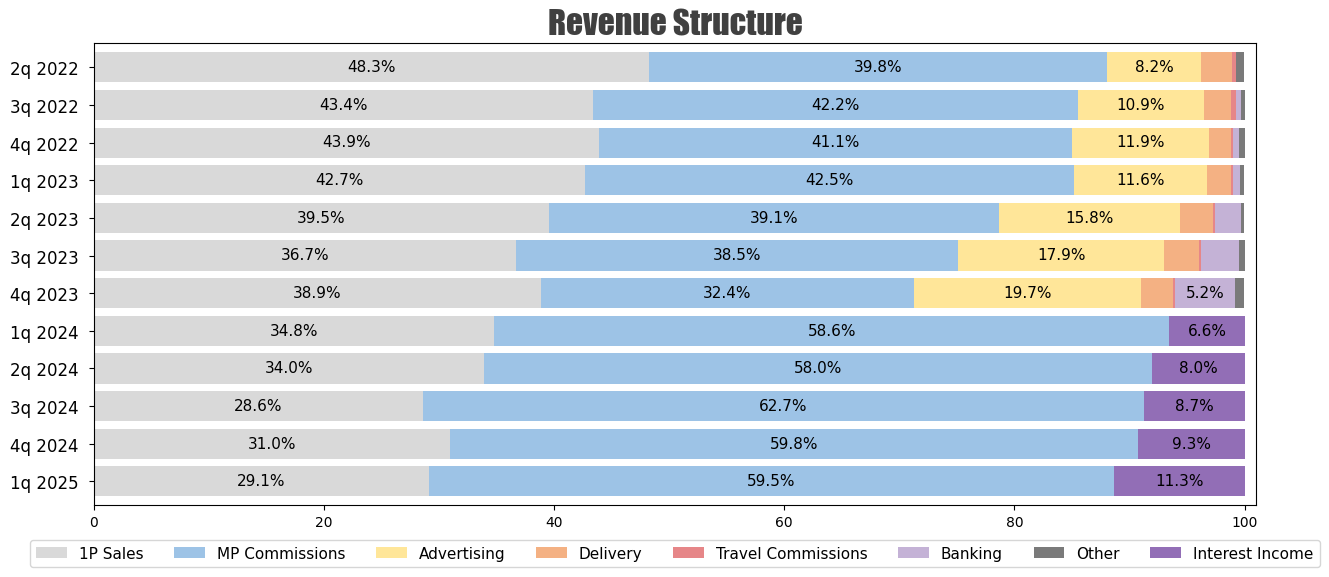

In [103]:
revenue_pct = round((revenue_structure.iloc[1:, -quarters_analysed:] / revenue_structure.iloc[1:, -quarters_analysed:].sum() * 100).astype(float), 2)
dates_line = pd.Series(range(quarters_analysed))

# Create a revenue pct graph
revenue_pct_figure, pcf = plt.subplots(figsize=(15, 6))
for i in range(len(revenue_pct)):
    pcf.barh(dates_line, width=revenue_pct.iloc[i], color=ozon_colors[i], label=labels[i], 
             left=revenue_pct.iloc[:i].sum())
for i in range(len(revenue_pct)):
    for j in range(revenue_pct.shape[1]):
        if revenue_pct.iloc[i, j] > 4:
            pcf.text(revenue_pct.iloc[:i + 1, j].sum() - revenue_pct.iloc[i, j] * 0.5, dates_line[j] + 0.1, 
                    str(round(revenue_pct.iloc[i, j], 1)) + '%', ha='center', fontsize=11)
pcf.set_title('Revenue Structure', fontsize=24, **font, color=f_colors[0])
pcf.invert_yaxis()
pcf.margins(x=0.01, y=0.02)
pcf.set_yticks(dates_line, dates_q, fontsize=12)
pcf.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=8, fontsize=11)
plt.show

This graph highlights the trend more effectively. Here, the increasing dominance of OZON's banking is more apparent. If it goes like this, in a few years OZON might start competing with the largest banks in Russia. Its client base is already larger than that of T-Bank (top 6 bank in Russia), which should make other bankers worried. 

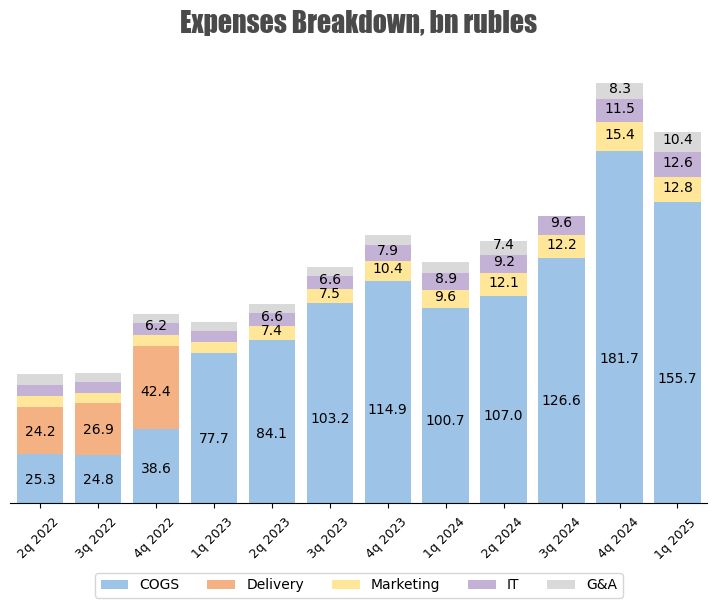

Total operating expenses RUB 191.6 bn
Pct change -53.8%


In [104]:
ozon_colors_exp = ['#9DC3E6', '#F4B183', '#FFE699', '#C4B2D6', '#D9D9D9', '#E68688']
exp_str = -ozon_plq.iloc[6:11, -quarters_analysed:]
labels_exp=['COGS', 'Delivery', 'Marketing', 'IT', 'G&A']
width_r=0.35

# Create an expenses plot
Expenses_figure, expv = plt.subplots(figsize=(9, 6))
expv.set_title('Expenses Breakdown, bn rubles', fontsize=20, **font, color=f_colors[0], alpha=0.95)
for i in range(len(exp_str)):
    expv.bar(dates_q, exp_str.iloc[i, -quarters_analysed:], color=ozon_colors_exp[i],
             bottom=exp_str.iloc[:i, -quarters_analysed:].sum(), label=labels_exp[i], width=0.8)
expv.xaxis.set_tick_params(rotation=45, labelsize=9)
expv.margins(x=0.01)
expv.set_ylim(0, exp_str.iloc[:, -quarters_analysed:].sum().max() * 1.1)
expv.legend(loc='lower center', bbox_to_anchor=(0.5, -0.22), ncol=len(exp_str))
for i in range(exp_str.shape[0]):
    for j in range(exp_str.shape[1]):
        if exp_str.iloc[i, j] > 6:
            expv.text(dates_q.iloc[j], exp_str.iloc[:i, j].sum() + exp_str.iloc[i, j] * 0.4,
                      str(round(exp_str.iloc[i, -quarters_analysed + j], 1)), ha='center')
for key, spine in expv.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
expv.yaxis.set_visible(False)
plt.show()
print(f"Total operating expenses RUB {round(-ozon_plq.iloc[6:11,-1].sum(), 1)} bn")
print(f"Pct change {round(-ozon_plq.iloc[6:11,-5:].sum().pct_change(4).dropna().item()*100, 1)}%")


Total operating expenses amounted to RUB 191.6 bn, +53.8% YoY. The main contributers are COSG and delivery (since 4Q 2022, both metrics have been disclosed as COGS); they grew by 54.7% and now represent 81% of all expenses. The dynamic here is a little bit slower in comparison to the revenue, which has a positive impact on the operating margin. 

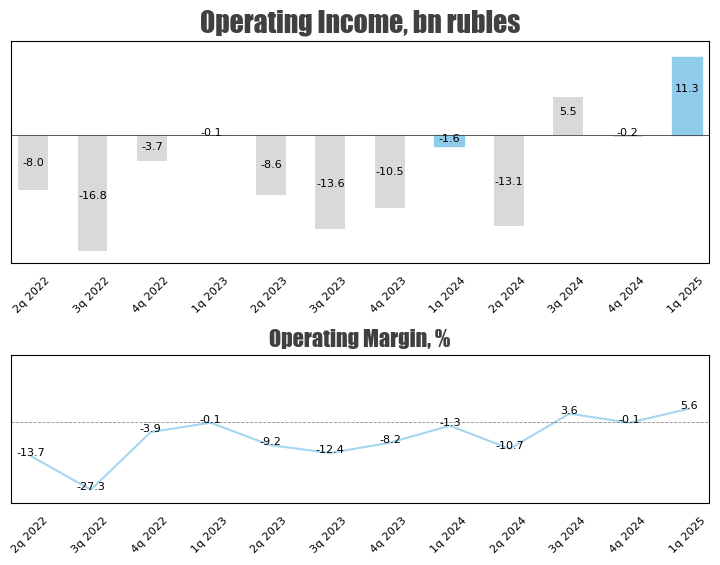

In [106]:
operating_maring = round((ozon_plq.iloc[11, -quarters_analysed:] / ozon_plq.iloc[1, -quarters_analysed:] * 100).astype(float), 1)

# Create an operating income graph
Oper_inc_figure, (opv, opm) = plt.subplots(2, 1, figsize=(9, 6), height_ratios=(1.5, 1))
bars = opv.bar(dates_q, ozon_plq.iloc[11, -quarters_analysed:], width=0.5, color=f_colors[2])
for i in [-1, -5]:
    bars[i].set_color(colors[3])
opv.xaxis.set_tick_params(rotation=45, labelsize=8)
opv.margins(x=0.01)
opv.set_ylim(ozon_plq.iloc[11, -quarters_analysed:].min() * 1.1, ozon_plq.iloc[11, -quarters_analysed:].max() * 1.2)
opv.axhline(y=0, color=f_colors[0], linewidth=0.6)
opv.yaxis.set_visible(False)
opv.xaxis.set_ticks_position('none')
opv.set_title('Operating Income, bn rubles', fontsize=20, **font, color=f_colors[0])
for i in range(len(ozon_plq.iloc[11, -quarters_analysed:])):
    opv.text(dates_q.iloc[i], ozon_plq.iloc[11, -quarters_analysed + i] * 0.55,
             str(round(ozon_plq.iloc[11, -quarters_analysed + i], 1)), fontsize=8, ha='center')
plt.subplots_adjust(hspace=0.5)
opm.plot(dates_q, operating_maring, color=colors[3], alpha=0.8)
opm.set_ylim(operating_maring.min() * 1.2, abs(operating_maring.min()))
opm.xaxis.set_tick_params(rotation=45, labelsize=8)
opm.axhline(y=0, color=f_colors[0], alpha=0.6, linewidth=0.6, ls='--')
opm.set_title('Operating Margin, %', color=f_colors[0], **font, fontsize=16)
opm.xaxis.set_ticks_position('none')
opm.yaxis.set_visible(False)
for i in range(len(dates_q)):
    opm.text(dates_q.iloc[i], operating_maring.iloc[i] + operating_maring.max() * 0.02, 
             str(round(operating_maring.iloc[i], 1)), ha='center', fontsize=8)
opm.margins(x=0.03)
plt.show()

And indeed, in 1Q 2025, OZON's operating margin grew to 5.6%, reaching RUB 11.3 bn in operating profit. Very good result, if compared to the previous quarters. However, there is still ample room for growth. Taking Amazon as an example, their operating margin is above 10%. Also, I believe that the banking business can increase this number even further, but for now these are just my speculations.   

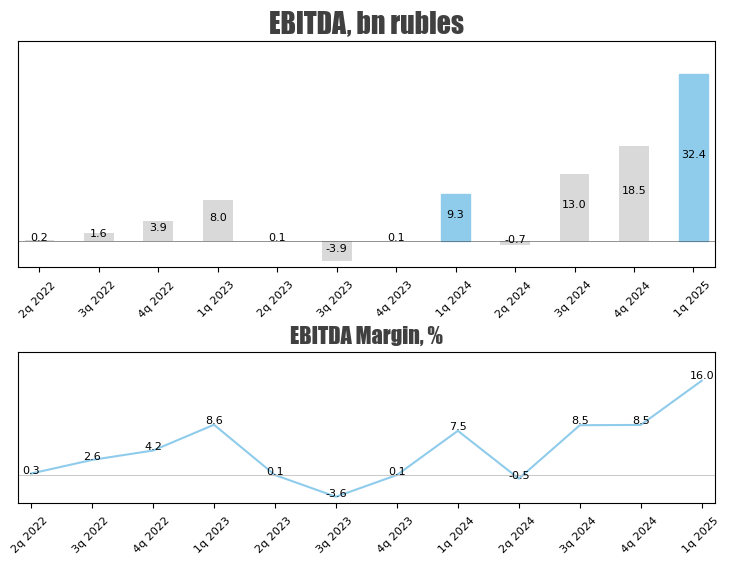

In [108]:
EBITDA_margin = round((ozon_plq.iloc[-1, -quarters_analysed:] / ozon_plq.iloc[1, -quarters_analysed:] * 100).astype(float), 2)

# Create an EBITDA graph
EBITDA_figure, (ebv, ebm) = plt.subplots(2, 1, figsize=(9,6), height_ratios=(1.5, 1))
bars = ebv.bar(dates_q, ozon_plq.iloc[-1, -quarters_analysed:], width=0.5, color=f_colors[2])
for i in [-1, -5]:
    bars[i].set_color(colors[3])
ebv.margins(x=0.01)
ebv.xaxis.set_tick_params(rotation=45, labelsize=8)
ebv.yaxis.set_visible(False)
ebv.axhline(y=0, color=f_colors[0], linewidth=0.4)
ebv.set_title('EBITDA, bn rubles', fontsize=20, color=f_colors[0], **font)
ebv.set_ylim(ozon_plq.iloc[-1, -quarters_analysed:].min() * 1.3, ozon_plq.iloc[-1, -quarters_analysed:].max() * 1.2)
for i in range(len(dates_q)):
    ebv.text(dates_q.iloc[i], ozon_plq.iloc[-1, -quarters_analysed + i] * 0.5, str(round(ozon_plq.iloc[-1, -quarters_analysed + i], 1)),
             ha='center', fontsize=8)
plt.subplots_adjust(hspace=0.45)
ebm.set_title('EBITDA Margin, %', fontsize=16, color=f_colors[0], **font)
ebm.plot(dates_q, EBITDA_margin, color=colors[3])
ebm.yaxis.set_visible(False)
ebm.xaxis.set_tick_params(rotation=45, labelsize=8)
ebm.margins(x=0.02)
ebm.set_ylim(EBITDA_margin.min() * 1.3, EBITDA_margin.max() * 1.3)
ebm.axhline(y=0, color=f_colors[1], linewidth=0.6)
for i in range(len(dates_q)):
    ebm.text(dates_q.iloc[i], EBITDA_margin.iloc[i] + EBITDA_margin.iloc[i].max() * 0.02, str(round(EBITDA_margin.iloc[i], 1)), 
             ha='center', fontsize=8)
plt.show()

The situation in EBITDA is even better. In the last quarter, it hit a record high of 16%, reaching RUB 32.4 bn. Positive news for all investors who were worried about potential insolvency. 

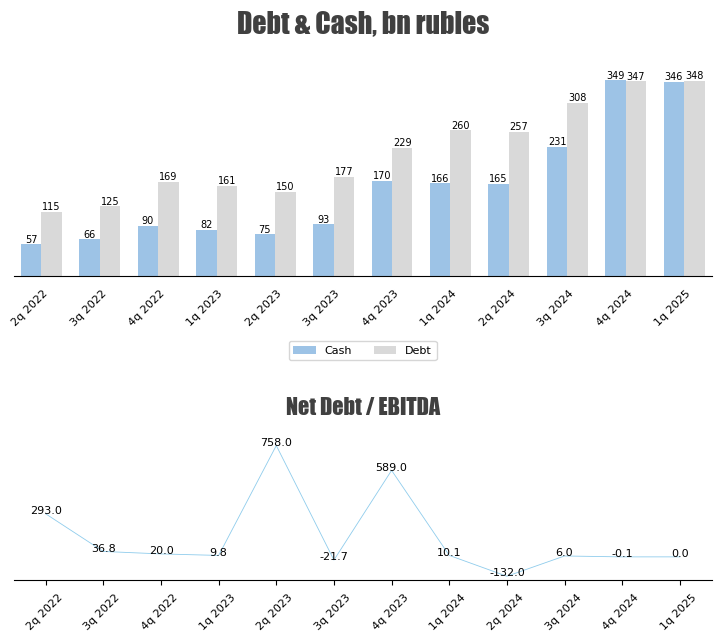

In [110]:
debt_cash = ozon_fr.iloc[[7,13], -quarters_analysed:] /1000000
width_debt = 0.35
labels_debt = ['Cash', 'Debt']

net_debt = round(((ozon_fr.iloc[13, -quarters_analysed:] / 1000000 - ozon_fr.iloc[7, -quarters_analysed:] / 1000000)).astype(float), 1).reset_index(drop=True)
EBITDA = round((ozon_plq.iloc[-1, -quarters_analysed:]).astype(float), 1).reset_index(drop=True)
Net_Debt_Ebitda = round(net_debt / EBITDA, 1) 

# Create a debt graph 
Debt_figure, (frd, fre) = plt.subplots(2, 1, figsize=(9, 7), height_ratios=(1.5, 1))
for i in range(debt_cash.shape[0]):
    frd.bar(dates_line + width_debt * i, debt_cash.iloc[i, :], width=width_debt, color=ozon_colors[1-i],
            label=labels_debt[i]) 
frd.xaxis.set_ticks(dates_line, dates_q, fontsize=8)  
frd.xaxis.set_tick_params(rotation=45, labelsize=8)
frd.set_title('Debt & Cash, bn rubles', fontsize=20, **font, color=f_colors[0])
frd.margins(x=0.01)
frd.set_ylim(0, debt_cash.max().max() * 1.2)
frd.legend(loc='lower center', bbox_to_anchor=(0.5, -0.38), ncol=len(labels_debt), fontsize=8)
frd.yaxis.set_visible(False)
for key, spine in frd.spines.items():
    if key != 'bottom': 
        spine.set_visible(False)
frd.xaxis.set_ticks_position('none')
for i in range(debt_cash.shape[0]):
    for j in range(debt_cash.shape[1]):
        frd.text(dates_line.iloc[j] + width_debt * i, debt_cash.iloc[i, j]+ debt_cash.max().max() * 0.01, str(round(debt_cash.iloc[i, j])),
                 ha='center', fontsize=7)
plt.subplots_adjust(hspace=0.75)
fre.set_title('Net Debt / EBITDA', fontsize=16, **font, color=f_colors[0])
fre.yaxis.set_visible(False)
for key, spine in fre.spines.items():
    if key !='bottom':
        spine.set_visible(False)
fre.xaxis.set_tick_params(rotation=45, labelsize=8)
fre.plot(dates_q, Net_Debt_Ebitda, color=colors[3], linewidth=0.6)
fre.set_ylim(Net_Debt_Ebitda.min() * 1.2, Net_Debt_Ebitda.max() * 1.2)
for i in range(len(Net_Debt_Ebitda)):
    fre.text(dates_q.iloc[i], Net_Debt_Ebitda.iloc[i], str(round(Net_Debt_Ebitda.iloc[i], 1)),
             ha='center', fontsize=8)
plt.show()

The amount of debt and cash has been staying at the same level for the last two quarters, around RUB 350 bn. As a result, the net debt is near zero, and the same applies to the net debt to EBITDA ratio. This should further reassure investors.    

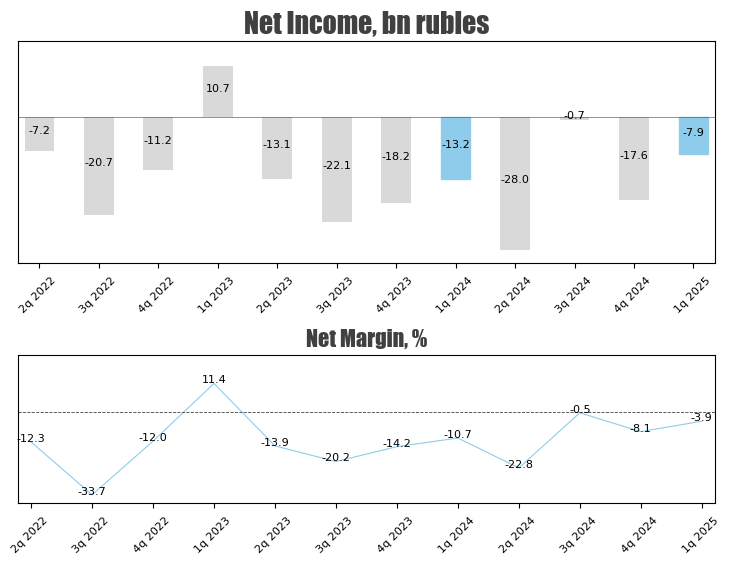

In [112]:
net_margin = round((ozon_plq.iloc[19, -quarters_analysed:] / ozon_plq.iloc[1, -quarters_analysed:] * 100).astype(float), 2)

# Create a profit graph
Profits_figure, (pfv, pfm) = plt.subplots(2,1, figsize=(9, 6), height_ratios=(1.5, 1))
bars = pfv.bar(dates_q, ozon_plq.iloc[19, -quarters_analysed:], width=0.5, color=f_colors[2])
for i in [-1, -5]:
    bars[i].set_color(colors[3])
pfv.xaxis.set_tick_params(rotation=45, labelsize=8)
pfv.set_title('Net Income, bn rubles', fontsize=20, **font, color=f_colors[0])
pfv.axhline(y=0, linewidth=0.4, color=f_colors[0])
pfv.margins(x=0.01)
pfv.set_ylim(ozon_plq.iloc[19, -quarters_analysed:].min() * 1.1, ozon_plq.iloc[19, -quarters_analysed:].max() * 1.5)
pfv.yaxis.set_visible(False)
for i in range(len(ozon_plq.iloc[19, -quarters_analysed:])):
    pfv.text(dates_q.iloc[i], ozon_plq.iloc[19, -quarters_analysed + i] * 0.5, 
             str(round(ozon_plq.iloc[19, -quarters_analysed + i], 1)), ha='center', fontsize=8)
plt.subplots_adjust(hspace=0.5)
pfm.plot(dates_q, net_margin, color=colors[3], linewidth=0.8)
pfm.set_title('Net Margin, %', fontsize=16, **font, color=f_colors[0])
pfm.yaxis.set_visible(False)
pfm.xaxis.set_tick_params(rotation=45, labelsize=8)
pfm.margins(x=0.02)
pfm.set_ylim(net_margin.min() * 1.1, net_margin.max() * 2)
pfm.axhline(y=0, color=f_colors[0], linewidth=0.6, ls='--')
for i in range(len(net_margin)):
    pfm.text(dates_q.iloc[i], net_margin.iloc[i] + net_margin.max() * 0.01, 
             str(round(net_margin.iloc[i], 1)), ha='center', fontsize=8)
plt.show()


Net income, however, remained negative. In Q1 2025, the loss amounted to RUB 7.9 bn, compared to RUB 13.2 bn a year earlier. The main reason is interest expenses; they stay high as the Central Bank continues to keep the key rate at 20%. Even though amortization offsets losses, it doesn't get reflected in the P&L. The good news is that the Central Bank is highly likely to lower the key rate in the near future if inflation remains low. 

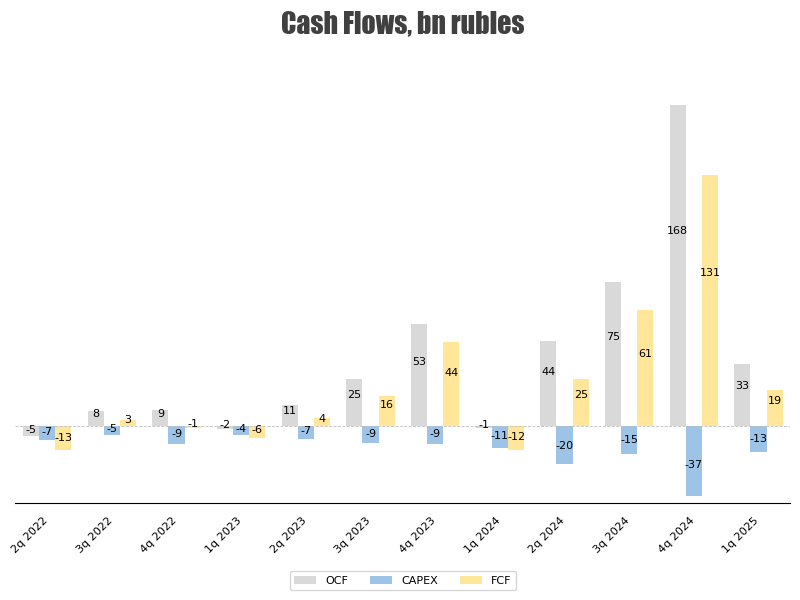

In [ ]:
cf_labels = ['OCF', 'CAPEX', 'FCF']
cash_flows = pd.DataFrame([ozon_cfq.iloc[20, -quarters_analysed:], ozon_cfq.iloc[42, -quarters_analysed:], (ozon_cfq.iloc[20, -quarters_analysed:] + ozon_cfq.iloc[42, -quarters_analysed:])], index=cf_labels)
cf_colors = ['#8FCCEC', '#D9D9D9','#F1D078']
cf_width = 0.25

# Create a cashflow graph
CF_figure, cfv = plt.subplots(figsize=(10, 6))
for i in range(cash_flows.shape[0]):
    cfv.bar(dates_line + cf_width * i, cash_flows.iloc[i, :], color=ozon_colors[i], width=cf_width, label=cf_labels[i])
for i in range(cash_flows.shape[0]):
    for j in range(cash_flows.shape[1]):
        cfv.text(dates_line.iloc[j] + cf_width * i, cash_flows.iloc[i, j] * 0.6, str(round(cash_flows.iloc[i, j])),
                 ha='center', fontsize=8)
cfv.set_title('Cash Flows, bn rubles', fontsize=20, **font, color=f_colors[0])
cfv.xaxis.set_ticks(dates_line, dates_q, fontsize=8)
cfv.xaxis.set_tick_params(rotation=45, labelsize=8)
cfv.margins(x=0.01)
cfv.yaxis.set_visible(False)
for key, spine in cfv.spines.items():
    spine.set_visible(False)
cfv.xaxis.set_ticks_position('none')
cfv.axhline(y=0, color=f_colors[1], linewidth=0.6, ls='--')
cfv.set_ylim(cash_flows.min().min() * 1.1, cash_flows.max().max() * 1.2)
cfv.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(cf_labels), fontsize=8)
cfv.axhline(y=0, color=f_colors[1], alpha=0.8, linewidth=0.6)
plt.show()



Additionally, it is worth mentioning that as the company slows down its expansion, its CAPEX starts to reduce as well. In the future, once they pay off the high-interest debt, the overall profitability will increase. 

# Predictions

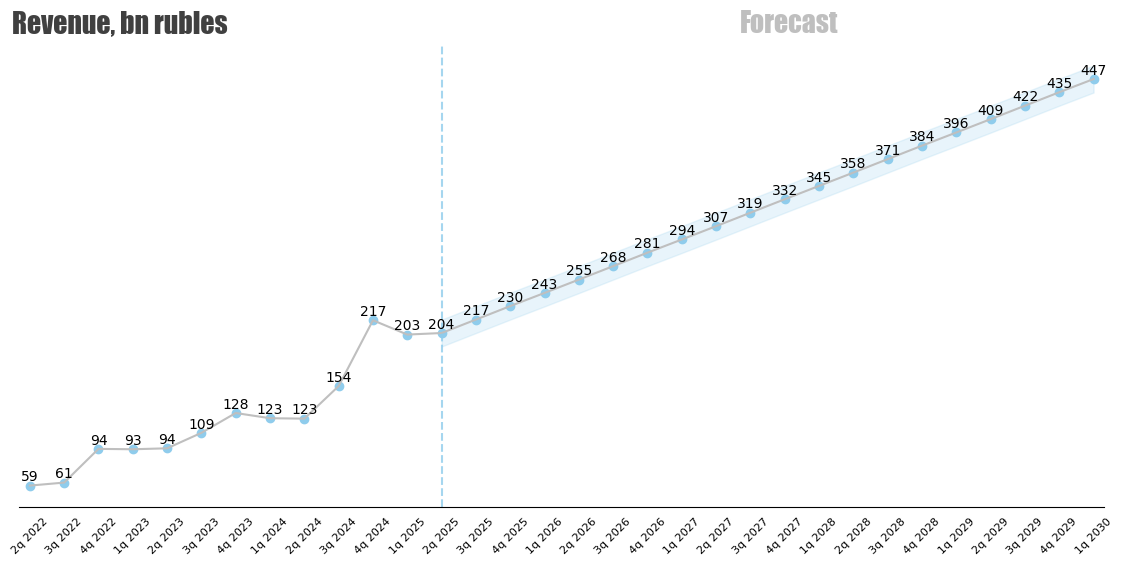

In [115]:
# Forecast revenue using time series 
model = LinearRegression()
revenue = ozon_plq.iloc[1, -quarters_analysed:].reset_index(drop=True)
dates = pd.to_datetime(dates_n, format='%d-%m-%Y').reset_index(drop=True)
days_since_start = (dates - dates.min()).dt.days # Display dates as the number of days since the earliest day for preditions 
model.fit(days_since_start.values.reshape(-1, 1), revenue)

last_date = dates.max() + pd.DateOffset(years=5)
quarterly_dates = pd.Series(pd.date_range(start=dates.max() + pd.DateOffset(months=3), end=last_date, freq='Q'))
all_dates = pd.concat([dates, quarterly_dates], ignore_index=True)


all_days_since_start = (all_dates - dates.min()).dt.days  
x = all_days_since_start.iloc[-20:].values.reshape(-1, 1)
predictions = model.predict(x)
future_revenue = pd.concat([revenue, round(pd.Series(predictions), 3)], ignore_index=True)

all_dates_q = all_dates.dt.quarter.astype(str) +'q ' + all_dates.dt.year.astype(str)

deviations = model.predict(all_days_since_start.iloc[:-20].values.reshape(-1, 1))
mae = mean_absolute_error(revenue, pd.Series(deviations))


# Visualise predictions 
Pred_fig, prv = plt.subplots(figsize=(14, 6))
prv.scatter(all_dates_q, future_revenue , color=colors[3], label='Actual Sales')
prv.plot(all_dates_q, future_revenue, color=f_colors[1], label='Regression Line')
prv.fill_between(all_dates_q.iloc[-20:], pd.to_numeric(future_revenue.iloc[-20:]+mae), 
                 pd.to_numeric(future_revenue.iloc[-20:]-mae), alpha=0.2, color=colors[3])
prv.xaxis.set_tick_params(rotation=45, labelsize=8)
prv.margins(x=0.01)
prv.yaxis.set_visible(False)
for i in range(len(all_dates_q)):
    prv.text(all_dates_q.iloc[i], future_revenue.iloc[i] + future_revenue.max() * 0.01, str(round(future_revenue.iloc[i])), 
             ha='center')
for key, spine in prv.spines.items():
    if key !='bottom':
        spine.set_visible(False)
prv.xaxis.set_ticks_position('none')
prv.axvline(x=all_dates_q.iloc[-20], linestyle='--', color=colors[3], alpha=0.8)
Pred_fig.text(0.64, 0.9, 'Forecast', fontsize=20, **font, color=f_colors[1])
Pred_fig.text(0.12, 0.9, 'Revenue, bn rubles', fontsize=20, **font, color=f_colors[0])
plt.show()

Current revenue projections imply a 25% CAGR over the next five years. A moderate figure given historical performance. Let's forecast the stock's future value. 

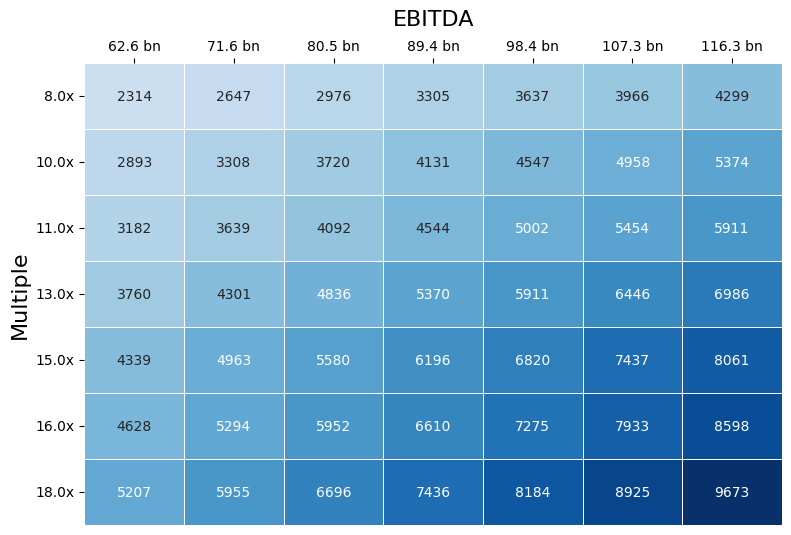

               Valuation  Potential, %
Current price     3943.0           0.0
Classic DCF       1298.0         -67.0
EBITDA mul 12     4960.0          26.0
EBITDA 2030 RUB 89.45 bn


In [ ]:

#Assumptions
tax_rate = 0.2
wacc = 0.20 
capex_coef = -0.08
ebitda_coef = np.linspace(EBITDA_margin.iloc[-1] / 100, 20 / 100, 20) # Assume the margin will grow from 15% to 20%
NWC_coef = -0.01
terminal_growth = 0.05

#Projections
projection = pd.DataFrame({'Dates':all_dates_q.iloc[-20:], 'Revenue':round(pd.to_numeric(future_revenue.iloc[-20:]), 2)})
projection['EBITDA'] = round(projection['Revenue'] * ebitda_coef, 2)
projection['Tax'] = round(projection['EBITDA'] * -tax_rate)
projection['CAPEX'] = round(projection['Revenue'] * capex_coef, 2)
projection['NWC'] = round(projection['Revenue'] * NWC_coef, 2)
projection['FCF'] = round(projection.iloc[:,2:].sum(axis=1) ,2)
projection['WACC'] = round(1 / (1+wacc/4)**pd.Series(range(1, len(projection)+1) , index=projection.index), 2)
projection['DFCF'] = round(projection['FCF'] * projection['WACC'], 2)

final_fcf = projection['FCF'].sum()
terminal_value = (final_fcf * (1 + terminal_growth)) / (wacc - terminal_growth)
pv_terminal = terminal_value * projection['WACC'].iloc[-1]


enterprise_value = projection['DFCF'].sum() + pv_terminal 
net_debt = (ozon_fr.iloc[[7,8], -1].sum() - ozon_fr.iloc[13, -1]) / 1000000
equity_value = enterprise_value - net_debt

shares = ozon_fr.iloc[17, -1]
fair_price = equity_value * 1000000000 / shares # Calculate a fair price per share 


ebitda_multiple = 12 # Current ration 
fair_price_mul = ebitda_multiple * projection['EBITDA'].iloc[-4:].sum() * projection['WACC'].iloc[-4:].mean() * 1000000000 / shares # Calculate a fair price per share using EBITDA multiple

current_price = ozon_fr.iloc[21, -1] # Current OZON's price

potential_table = pd.DataFrame({
    'Current price': current_price,
    'Classic DCF': round(fair_price), 
    'EBITDA mul 12': round(fair_price_mul)},
    index=['Valuation']).T
potential_table['Potential, %'] = round((potential_table['Valuation'] - potential_table['Valuation'].iloc[0]) / potential_table['Valuation'].iloc[0] * 100)
potential_table



#Sensitivity analysis 
EBITDA_multpl_range = np.linspace(8, 16, 7).round()
EBITDA_range = np.linspace(projection['EBITDA'].iloc[-4:].sum() * 0.7, projection['EBITDA'].iloc[-4:].sum()*1.3, 7).round(1)  
  
sensitivity_table = pd.DataFrame(columns=[f"{e} bn" for e in EBITDA_range], index=[f"{b}x" for b in EBITDA_multpl_range])
 
for  ebitda in EBITDA_range:
    sensitivity_table[f"{ebitda} bn"] = (ebitda * EBITDA_multpl_range* projection['WACC'].iloc[-4:].mean() * 1_000_000_000 / shares).round().astype(int)


#Sensitivity heatmap
Sensitivity_figure, sng = plt.subplots(figsize=(9,6))
sng = sns.heatmap(sensitivity_table, center=fair_price_mul, annot=True, fmt=".0f", cmap='Blues', 
                  linewidths=0.5, ax=sng, cbar=False)  
sng.tick_params(axis='x', which='both', top=True, labeltop=True, labelbottom=False)
sng.xaxis.set_ticks_position('top')
sng.yaxis.set_tick_params(rotation=0)
sng.xaxis.set_label_position('top')  # Move the label to the top
sng.set_xlabel('EBITDA', fontsize=16, labelpad=10)  
sng.set_ylabel('Multiple', fontsize=16)
plt.show()
print(potential_table, end='\n\n')
print(f"LTM EBITDA 2025/2030  RUB {round(ozon_plq.iloc[-1, -4:].sum(), 1)} / RUB {round(projection['EBITDA'].iloc[-4:].sum(), 1)} bn")


The DCF model suggests a fair price of RUB 1,298 per share (-68% vs. current). If we use a multiples-based approach, the fair price will be significantly higher, at RUB 4960 (+23% vs. the current price). I believe the multiples-based approach is better for IT companies and fast-growing startups because DCFs often understate their full potential due to inadequacies in long-term assumptions. Simply put, long-term assumptions are extremely difficult for fast-growing companies, which is why the multiples-based approach is preferable.

The sensitivity table shows how the fair price varies with changes to the 2030 EBITDA estimate and multiple. 
Overall, I maintain a positive outlook on the company and anticipate an upward revision in its valuation once economic conditions stabilize.